# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [56]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [57]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

saved_lats = []
saved_longs = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    #also add estimated latitude and longitude
    if city not in cities:
        cities.append(city)
        saved_lats.append(lat_lng[0])
        saved_longs.append(lat_lng[1])
        
# print(citipy.nearest_city(0, 0).keys())

# Print the city count to confirm sufficient count
print("{} cities have been identified to poll for weather".format(len(cities)))

city_list = pd.DataFrame({"City":cities, "Approx. Latitude":saved_lats, "Approx. Longitude":saved_longs})
# city_list = pd.DataFrame({"City":cities})

#save to a csv (for reference - can compare estimated coordinates to actual coordinates if there is time, which cannot be done
#easily with citipy because the references only go one way -> approx. coordinates to city name, not city name to actual 
#coordinates)
city_list.to_csv("./CityNameList.csv")
city_list.head()

608 cities have been identified to poll for weather


,City,Approx. Latitude,Approx. Longitude
0,bredasdorp,-80.318442,15.532365
1,vaini,-86.226736,-175.515797
2,norman wells,74.582597,-120.095072
3,charlestown,15.318038,-64.231231
4,okha,54.451828,142.697843


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [58]:
#url for advanced mapping using OpenWeatherMap's new OneCall API to get historical weather info by coordinates instead of 
#city names - not implemented for project initially due to setup being different
# base_url = "https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude={part}&appid={YOUR API KEY}"
# params = {"exclude":"minutely,hourly,current", "appid":weather_api_key, "lat":city_list["Latitude"][0], 
#           "lon":city_list["Longitude"][0]}

#setup columns for temperature, humidity, cloudiness, and wind speed
city_list["Max Temperature (F)"] = ""
city_list["Humidity (%)"] = ""
city_list["Cloudiness"] = ""
city_list["Wind Speed (mph)"] = ""

#setup columns for actual latitude and longitude
city_list["Actual Latitude"] = ""
city_list["Actual Longitude"] = ""

#setup column for country code
city_list["Country"] = ""

#setup column for city datetime
city_list["Datetime (Local)"] = ""
#note that current timezone is PST (-7:00 from GMT)
PST_offset = 7*60*60


base_url_current = "http://api.openweathermap.org/data/2.5/weather"
params = {"q":city_list["City"][0], "units":"imperial", "appid":weather_api_key}

test_response = requests.get(base_url_current, params)
json_response = test_response.json()
# json.dumps(json_response, indent=4)


#establish pattern for getting data into columns from json object
city_list["Actual Latitude"][0] = json_response["coord"]["lat"]
city_list["Actual Longitude"][0] = json_response["coord"]["lon"]
city_list["Max Temperature (F)"][0] = json_response["main"]["temp_max"]
city_list["Humidity (%)"][0] = json_response["main"]["humidity"]
city_list["Cloudiness"][0] = json_response["clouds"]["all"]
city_list["Wind Speed (mph)"][0] = json_response["wind"]["speed"]
city_list["Country"][0] = json_response["sys"]["country"]
#create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
#computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
first_city_time = datetime.datetime.fromtimestamp(json_response["dt"]+json_response["timezone"]+PST_offset)
city_list["Datetime (Local)"][0] = "{} {}".format(first_city_time.date(), first_city_time.time())

#create helper function to give the Datetime (UTC) column string
def getTimeString(resp_json, comp_time):
    curr_city_datetime = datetime.datetime.fromtimestamp(resp_json["dt"]+resp_json["timezone"]+comp_time)
    return "{} {}".format(curr_city_datetime.date(), curr_city_datetime.time())

#create function to add all info to dataframe using the above pattern 
def addColumns(pd_df, resp_json, i, comp_time):
    pd_df["Actual Latitude"][i] = resp_json["coord"]["lat"]
    pd_df["Actual Longitude"][i] = resp_json["coord"]["lon"]
    pd_df["Max Temperature (F)"][i] = resp_json["main"]["temp_max"]
    pd_df["Humidity (%)"][i] = resp_json["main"]["humidity"]
    pd_df["Cloudiness"][i] = resp_json["clouds"]["all"]
    pd_df["Wind Speed (mph)"][i] = resp_json["wind"]["speed"]
    pd_df["Country"][i] = resp_json["sys"]["country"]
    #create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
    #computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
    pd_df["Datetime (Local)"][i] = getTimeString(resp_json, comp_time)
        


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A valu

In [66]:
#loop over rows in dataframe to gather info for each city's weather
#put in its own cell to allow running separately from the test/setup of the API calls
record_count = len(city_list)

for i, row in city_list.iterrows():
    #use try/except construct to skip over missing cities or missing info
    try:
        params["q"] = row["City"]
        response = requests.get(base_url_current, params)
        json_resp = response.json()
        addColumns(city_list, json_resp, i, PST_offset)
        print("Retrieved record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
    except:
        city_list["City"][i] = "Failed"
        print("Could not retrieve record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
        

city_list.head()

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A valu

Retrieved record 1 of 608 for the city of bredasdorp
Retrieved record 2 of 608 for the city of vaini
Retrieved record 3 of 608 for the city of norman wells
Retrieved record 4 of 608 for the city of charlestown
Retrieved record 5 of 608 for the city of okha
Retrieved record 6 of 608 for the city of ushuaia
Retrieved record 7 of 608 for the city of nikolskoye
Retrieved record 8 of 608 for the city of hithadhoo
Retrieved record 9 of 608 for the city of watsa
Retrieved record 10 of 608 for the city of hermanus
Retrieved record 11 of 608 for the city of mataura
Retrieved record 12 of 608 for the city of wasilla
Retrieved record 13 of 608 for the city of muhos
Retrieved record 14 of 608 for the city of rajshahi
Could not retrieve record 15 of 608 for the city of toliary


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Retrieved record 16 of 608 for the city of chokurdakh
Retrieved record 17 of 608 for the city of rikitea
Retrieved record 18 of 608 for the city of muswellbrook
Retrieved record 19 of 608 for the city of katsuura
Could not retrieve record 20 of 608 for the city of amderma
Retrieved record 21 of 608 for the city of teluk nibung
Retrieved record 22 of 608 for the city of tasiilaq
Retrieved record 23 of 608 for the city of lomza
Retrieved record 24 of 608 for the city of tanabe
Retrieved record 25 of 608 for the city of busselton
Retrieved record 26 of 608 for the city of puerto ayora
Could not retrieve record 27 of 608 for the city of mys shmidta
Retrieved record 28 of 608 for the city of bubaque
Retrieved record 29 of 608 for the city of tamandare
Retrieved record 30 of 608 for the city of barpali
Retrieved record 31 of 608 for the city of atuona
Retrieved record 32 of 608 for the city of saint george
Retrieved record 33 of 608 for the city of bethel
Retrieved record 34 of 608 for the c

Retrieved record 168 of 608 for the city of lukovetskiy
Retrieved record 169 of 608 for the city of airai
Retrieved record 170 of 608 for the city of sao miguel do araguaia
Retrieved record 171 of 608 for the city of hualmay
Retrieved record 172 of 608 for the city of kashi
Retrieved record 173 of 608 for the city of bentiu
Retrieved record 174 of 608 for the city of biltine
Retrieved record 175 of 608 for the city of kozhva
Retrieved record 176 of 608 for the city of santa catalina
Retrieved record 177 of 608 for the city of ahipara
Retrieved record 178 of 608 for the city of rorvik
Retrieved record 179 of 608 for the city of sao joao da barra
Retrieved record 180 of 608 for the city of santa vitoria do palmar
Retrieved record 181 of 608 for the city of mafra
Retrieved record 182 of 608 for the city of cherskiy
Retrieved record 183 of 608 for the city of geraldton
Retrieved record 184 of 608 for the city of tabou
Retrieved record 185 of 608 for the city of pizhma
Retrieved record 186 

Retrieved record 320 of 608 for the city of bilma
Retrieved record 321 of 608 for the city of xining
Retrieved record 322 of 608 for the city of ouargaye
Retrieved record 323 of 608 for the city of salalah
Retrieved record 324 of 608 for the city of vostok
Retrieved record 325 of 608 for the city of moyale
Retrieved record 326 of 608 for the city of playa vicente
Retrieved record 327 of 608 for the city of prince rupert
Retrieved record 328 of 608 for the city of corinto
Retrieved record 329 of 608 for the city of port-gentil
Retrieved record 330 of 608 for the city of rostovka
Retrieved record 331 of 608 for the city of yate
Retrieved record 332 of 608 for the city of porbandar
Retrieved record 333 of 608 for the city of melo
Retrieved record 334 of 608 for the city of atasu
Retrieved record 335 of 608 for the city of luderitz
Retrieved record 336 of 608 for the city of mandalgovi
Retrieved record 337 of 608 for the city of naryan-mar
Retrieved record 338 of 608 for the city of riyadh

Retrieved record 472 of 608 for the city of pochutla
Retrieved record 473 of 608 for the city of gornopravdinsk
Retrieved record 474 of 608 for the city of ugoofaaru
Retrieved record 475 of 608 for the city of carlyle
Retrieved record 476 of 608 for the city of sangar
Retrieved record 477 of 608 for the city of rawson
Retrieved record 478 of 608 for the city of beringovskiy
Retrieved record 479 of 608 for the city of tiznit
Could not retrieve record 480 of 608 for the city of doctor pedro p. pena
Retrieved record 481 of 608 for the city of kruisfontein
Retrieved record 482 of 608 for the city of bay saint louis
Retrieved record 483 of 608 for the city of gigmoto
Retrieved record 484 of 608 for the city of antalaha
Retrieved record 485 of 608 for the city of juneau
Retrieved record 486 of 608 for the city of caramay
Retrieved record 487 of 608 for the city of aripuana
Retrieved record 488 of 608 for the city of klaksvik
Retrieved record 489 of 608 for the city of ishigaki
Retrieved reco

,City,Approx. Latitude,Approx. Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,bredasdorp,-80.318442,15.532365,55.4,82,8,10.29,-34.53,20.04,ZA,2020-06-29 01:39:56
1,vaini,-86.226736,-175.515797,78.8,88,75,10.29,-21.2,-175.2,TO,2020-06-29 12:38:34
2,norman wells,74.582597,-120.095072,75.2,27,40,2.77,65.28,-126.83,CA,2020-06-28 17:39:56
3,charlestown,15.318038,-64.231231,55,93,57,5.68,-32.95,151.67,AU,2020-06-29 09:35:58
4,okha,54.451828,142.697843,48.88,90,98,3.47,53.57,142.95,RU,2020-06-29 10:39:56


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [92]:
remaining_cities = city_list.loc[city_list["City"] != "Failed"]
city_left_count = len(remaining_cities)
print("There is data for {} cities out of the {} cities identified, for a retrieval success rate of {:.1%}"
      .format(city_left_count, record_count, (city_left_count/record_count)))

remaining_cities.index = [a for a in range(city_left_count)]


#must change all the columns other than the three below to numeric types - 
#they are currently strings!
non_numeric_cols = ["City", "Country", "Datetime (Local)"]

for col in remaining_cities.columns:
    if(col not in non_numeric_cols):
        remaining_cities[col] = pd.to_numeric(remaining_cities[col])
        
remaining_cities.dtypes
remaining_cities

There is data for 554 cities out of the 608 cities identified, for a retrieval success rate of 91.1%


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


City                    object
Approx. Latitude       float64
Approx. Longitude      float64
Max Temperature (F)    float64
Humidity (%)             int64
Cloudiness               int64
Wind Speed (mph)       float64
Actual Latitude        float64
Actual Longitude       float64
Country                 object
Datetime (Local)        object
dtype: object

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [96]:
#check if there are any cities with >100% humidity
test_stats = remaining_cities["Humidity (%)"].describe(include = "all")
print("By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!")
test_stats

By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!


count    554.000000
mean      72.005415
std       19.973173
min        3.000000
25%       63.000000
50%       76.000000
75%       86.000000
max      100.000000
Name: Humidity (%), dtype: float64

In [7]:
#  Get the indices of cities that have humidity over 100%.

Int64Index([], dtype='int64')

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,pimentel,-6.84,-79.93,66.20,29,75,5.82,PE,1585764415
1,victoria,22.29,114.16,69.01,88,40,18.34,HK,1585764288
2,padang,-0.95,100.35,79.90,75,99,1.63,ID,1585764115
3,hasaki,35.73,140.83,55.00,100,75,4.70,JP,1585764415
4,kahului,20.89,-156.47,70.00,88,1,7.63,US,1585764415


In [97]:
# Extract relevant fields from the data frame


# Export the City_Data into a csv
remaining_cities.to_csv("../output_data/Retrieved_City_Weather_Data.csv")
remaining_cities

,City,Approx. Latitude,Approx. Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,bredasdorp,-80.318442,15.532365,55.40,82,8,10.29,-34.53,20.04,ZA,2020-06-29 01:39:56
1,vaini,-86.226736,-175.515797,78.80,88,75,10.29,-21.20,-175.20,TO,2020-06-29 12:38:34
2,norman wells,74.582597,-120.095072,75.20,27,40,2.77,65.28,-126.83,CA,2020-06-28 17:39:56
3,charlestown,15.318038,-64.231231,55.00,93,57,5.68,-32.95,151.67,AU,2020-06-29 09:35:58
4,okha,54.451828,142.697843,48.88,90,98,3.47,53.57,142.95,RU,2020-06-29 10:39:56
...,...,...,...,...,...,...,...,...,...,...,...
549,acari,-20.981800,-77.344132,64.96,56,12,2.24,-15.43,-74.62,PE,2020-06-28 18:41:52
550,mackay,-21.423984,148.919434,68.00,77,40,12.75,-21.15,149.20,AU,2020-06-29 09:41:32
551,dolores,-37.084143,-56.647215,42.15,80,83,6.64,-36.31,-57.68,AR,2020-06-28 20:41:53
552,jizan,16.565623,43.014889,91.40,75,20,4.70,17.33,42.67,SA,2020-06-29 02:41:53


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

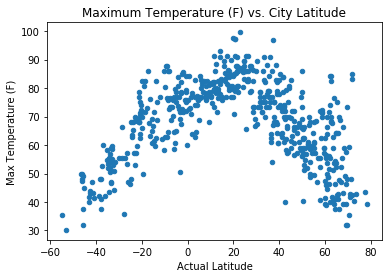

In [107]:
lat_vs_T_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Max Temperature (F)", 
                                      title="Maximum Temperature (F) vs. City Latitude")

lat_vs_T_axes.get_figure().savefig("../output_data/Fig1.png")

## Latitude vs. Humidity Plot

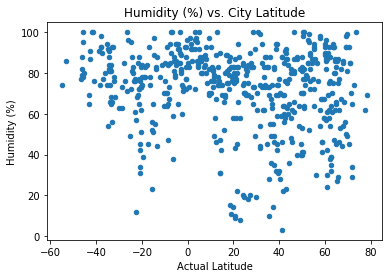

In [108]:
lat_vs_humidity_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Humidity (%)", 
                                      title="Humidity (%) vs. City Latitude")

lat_vs_humidity_axes.get_figure().savefig("../output_data/Fig2.png")

## Latitude vs. Cloudiness Plot

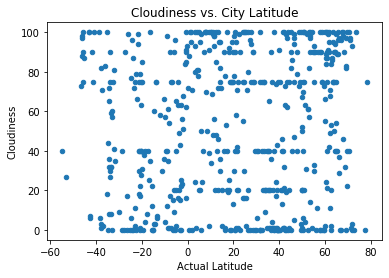

In [109]:
lat_vs_cloudiness_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Cloudiness", 
                                      title="Cloudiness vs. City Latitude")

lat_vs_cloudiness_axes.get_figure().savefig("../output_data/Fig3.png")

## Latitude vs. Wind Speed Plot

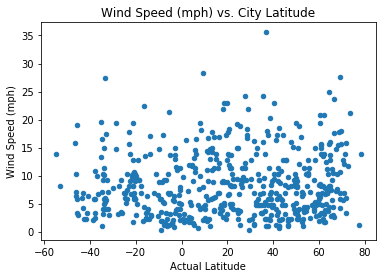

In [110]:
lat_vs_wind_speed_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Wind Speed (mph)", 
                                      title="Wind Speed (mph) vs. City Latitude")

lat_vs_wind_speed_axes.get_figure().savefig("../output_data/Fig4.png")

## Linear Regression

In [14]:
# OPTIONAL: Create a function to create Linear Regression plots

In [113]:
# Create Northern and Southern Hemisphere DataFrames

#first, get a subset of all the cities that are on or north of the equator for the Northern Hemisphere DataFrame
northern_hemisphere = remaining_cities.loc[remaining_cities["Actual Latitude"] >= 0]
northern_cities_count = len(northern_hemisphere)
print("There are {} cities in the northern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(northern_cities_count, city_left_count, (northern_cities_count/city_left_count)))

southern_hemisphere = remaining_cities.loc[remaining_cities["Actual Latitude"] < 0]
southern_cities_count = len(southern_hemisphere)
print("There are {} cities in the southern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(southern_cities_count, city_left_count, (southern_cities_count/city_left_count)))


There are 385 cities in the northern hemisphere out of 554 cities total, representing 69.5% of all cities in the data set.
There are 169 cities in the southern hemisphere out of 554 cities total, representing 30.5% of all cities in the data set.


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.8271188905041935


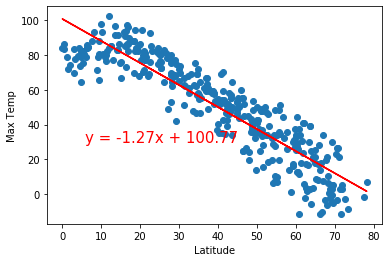

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.39936284758885965


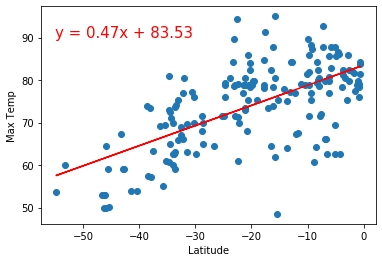

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.10829462153873139


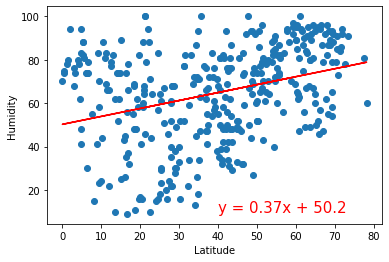

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.0008996079328825663


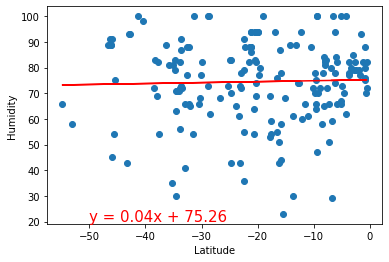

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.05768812657005063


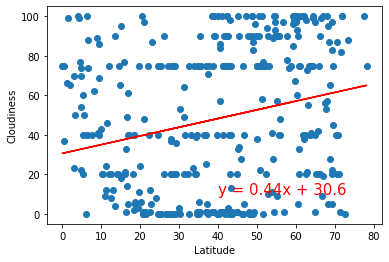

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.0684912094859049


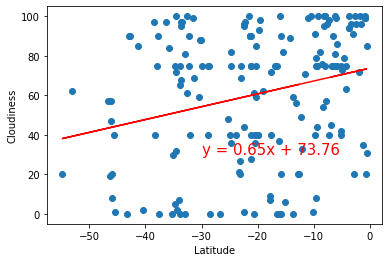

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.023371104533850804


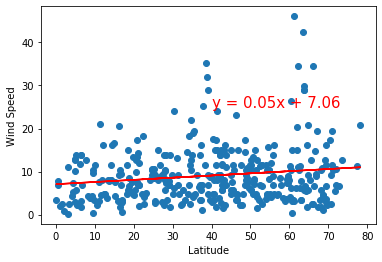

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.03381889207758188


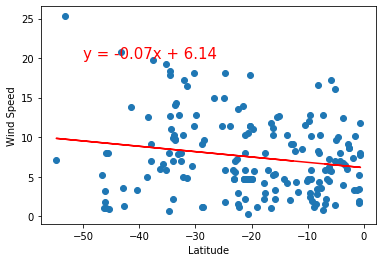